## Анализ данных о покупках

**Задачи:**
- Выполнить предварительную обработку данных;
- Cделать разведочный анализ данных EDA;
- Проверить гипотезу о данных;
- Выполнить кластеризацию по товарам;
- Определить важные признаки;
- Построить рекомендательную систему.

Датасет - информация о покупках клиентов:

**Дата** - время покупки

**Транзакция** - уникальный номер покупки

**Клиент** - уникальный номер клиента

**Товар** - уникальный номер товара

**Количество** - количество купленных товаров

**Сумма** - цена покупки этого товара

### 1. Импорт библиотек

**Загружаем все необходимые библиотеки и настройки для графиков.**

In [1]:
import pandas as pd
import seaborn as sns
import datetime as dt
import numpy as np
import matplotlib
import math, random
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors  
from scipy.sparse import csr_matrix 
from collections import defaultdict, Counter

%matplotlib inline

# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

# увеличим дефолтный размер графиков
from pylab import rcParams

rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid", {'axes.grid' : True})

### 2. Загрузка данных

**Загружаем наш датасет с данными о покупках с помощью библиотеки pandas.**

In [2]:
df = pd.read_csv('dataset.csv', sep = ';')
df.head(10)

,Дата,Транзакция,Клиент,Товар,Количество,Сумма
0,03.05.2020 21:43,954,1,2874.0,1.0,8150.0
1,20.11.2020 20:46,13796,1,3586.0,1.0,3930.0
2,08.12.2020 16:28,14431,1,4942.0,1.0,2860.0
3,03.05.2020 21:15,951,2,2812.0,1.0,4895.0
4,20.05.2020 16:46,3352,2,5025.0,1.0,840.0
5,19.09.2020 20:26,10240,2,2741.0,1.0,5790.0
6,19.09.2020 20:26,10240,2,2231.0,1.0,27400.0
7,19.09.2020 20:26,10240,2,2634.0,1.0,5095.0
8,19.09.2020 20:26,10240,2,1958.0,1.0,8320.0
9,16.05.2021 14:38,22180,2,1924.0,1.0,13200.0


### 3. Очистка данных

**Преобразование данных, обработка пропусков, удаление дубликатов**

In [3]:
# Посмотрим на наш объем данных для исследования.

df.shape

(48303, 6)

In [4]:
# Посмотрим общую информацию о нашем датасете и типах его данных.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48303 entries, 0 to 48302
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Дата        48303 non-null  object 
 1   Транзакция  48303 non-null  int64  
 2   Клиент      48303 non-null  int64  
 3   Товар       48273 non-null  float64
 4   Количество  48303 non-null  float64
 5   Сумма       48303 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
# Удалим дубликаты(идентичные строки) в наших данных если они есть и посмотрим как изменился объем нашего датасета. 

df = df.drop_duplicates()
df.shape

(47175, 6)

**Проверим наши значения на уникальность.** 

**Так как признаков у нас всего лишь 6, проверим на уникальность каждый признак в отдельности.**

In [6]:
df['Дата'].unique()

array(['03.05.2020 21:43', '20.11.2020 20:46', '08.12.2020 16:28', ...,
       '06.07.2021 15:00', '06.07.2021 15:13', '06.07.2021 15:02'],
      dtype=object)

In [7]:
df['Транзакция'].unique()

array([  954, 13796, 14431, ..., 25398, 25399, 25412], dtype=int64)

In [8]:
df['Клиент'].unique()

array([    1,     2,     3, ..., 11048, 11049, 11050], dtype=int64)

In [9]:
df['Товар'].unique()

array([2874., 3586., 4942., ..., 3516., 4151., 2334.])

In [10]:
df['Количество'].unique()

array([1.])

In [11]:
df['Сумма'].unique()

array([ 8150.  ,  3930.  ,  2860.  , ..., 17989.98, 19989.98, 14605.  ])

In [12]:
'''Так как в столбце "Дата" содержится одновременно дата и время, мы извлечем дату в отдельную колонку "Дата2", а потом мы 
изменим тип значений столбца "Дата" и "Дата2" из 'object' в 'datetime' для дальнейшей работы с ними.'''

df['Дата2'] = pd.to_datetime(df['Дата']).dt.date
df['Дата'] = pd.to_datetime(df['Дата'])
df['Дата2'] = pd.to_datetime(df['Дата2'])
df.head()

,Дата,Транзакция,Клиент,Товар,Количество,Сумма,Дата2
0,2020-03-05 21:43:00,954,1,2874.0,1.0,8150.0,2020-03-05
1,2020-11-20 20:46:00,13796,1,3586.0,1.0,3930.0,2020-11-20
2,2020-08-12 16:28:00,14431,1,4942.0,1.0,2860.0,2020-08-12
3,2020-03-05 21:15:00,951,2,2812.0,1.0,4895.0,2020-03-05
4,2020-05-20 16:46:00,3352,2,5025.0,1.0,840.0,2020-05-20


In [13]:
'''Так как признак "Количество" у нас имеет тип float(число с плавующей точкой), преобразуем тип значений данного признака в 
int(целое число) для упрощения работы с данным признаком. И выведем общую информацию по данным для проверки преобразования 
признаков.'''

df = df.astype({'Количество' : int})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47175 entries, 0 to 48302
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Дата        47175 non-null  datetime64[ns]
 1   Транзакция  47175 non-null  int64         
 2   Клиент      47175 non-null  int64         
 3   Товар       47146 non-null  float64       
 4   Количество  47175 non-null  int32         
 5   Сумма       47175 non-null  float64       
 6   Дата2       47175 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int32(1), int64(2)
memory usage: 2.7 MB


In [14]:
# Произведем проверку наших данных на содержание пустых значений по количеству и посмотрим их процентное соотношение.

print(df.isnull().sum())
print('')
print('')
print(df.isnull().mean() * 100)

Дата           0
Транзакция     0
Клиент         0
Товар         29
Количество     0
Сумма          0
Дата2          0
dtype: int64


Дата          0.000000
Транзакция    0.000000
Клиент        0.000000
Товар         0.061473
Количество    0.000000
Сумма         0.000000
Дата2         0.000000
dtype: float64


In [15]:
'''Проверив признаки на наличие пустых значений, мы нашли 29  пустых значений в признаке "Товар". Оставляем данные в 
датафрейме те, которые не нулевые, т.е. таким образом избавляемся от пустых значений в признаке "Товар". '''

df = df[~df['Товар'].isnull()]

In [16]:
# Повторно проверяем наши данные на наличие пустых значений после их удаления.

df.isnull().sum()

Дата          0
Транзакция    0
Клиент        0
Товар         0
Количество    0
Сумма         0
Дата2         0
dtype: int64

In [17]:
# После удаления строк с пустыми значениями посмотрим еще раз на объем наших данных.

df.shape

(47146, 7)

### 4. EDA 
 
**Описательная статистика, поиск взаимосвязей**

In [18]:
'''Выведем статистические показатели по признаку "Количество" и "Сумма", а именно: общее количество, среднее, среднее 
квадратическое отклонение, минимальное и максимальное значение и квантили.'''
 
df[['Количество', 'Сумма']].describe()

,Количество,Сумма
count,47146.0,47146.000000
mean,1.0,10455.257645
std,0.0,12701.269894
min,1.0,504.000000
25%,1.0,3810.000000
50%,1.0,6910.000000
75%,1.0,12750.000000
max,1.0,511500.000000


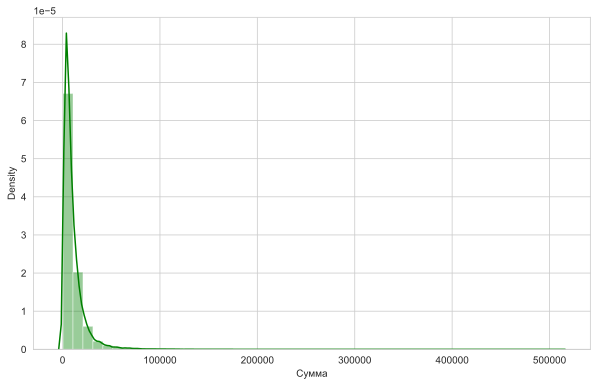

In [19]:
#График распределения плотности

sns.distplot(df["Сумма"].astype(int), color = 'g')
plt.show()

**Вывод:**

    График распределения плотности нам показывает, что наши данные не распределены нормально, они смещены в лево.

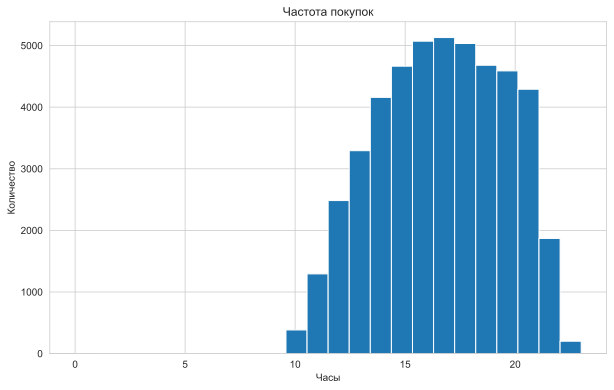

In [20]:
# Построим стобчатую диаграмму частоты покупок от количество часов.

plt.hist(df['Дата'].dt.hour.values, bins=24)
plt.title('Частота покупок')
plt.xlabel('Часы')
plt.ylabel('Количество')
plt.show()

**Вывод:**

    По графику можем сказать, что большинство подтвержденных случаев приходится на часы от 15 до 20.

In [21]:
'''Для возможности построения графика зависимости даты от суммы продаж, создадим новый датафрейм по общей сумме продаж по каждой
дате.'''

df2 = df[['Сумма', 'Дата2']].groupby('Дата2').sum().sort_values('Дата2', ascending = True)
df2.reset_index(drop = False, inplace = True)
df2

,Дата2,Сумма
0,2020-01-05,2999052.96
1,2020-01-06,184500.00
2,2020-01-07,430400.00
3,2020-01-08,208770.00
4,2020-01-09,926915.00
...,...,...
461,2021-12-03,234379.50
462,2021-12-04,517908.50
463,2021-12-05,1578498.87
464,2021-12-06,2131892.95


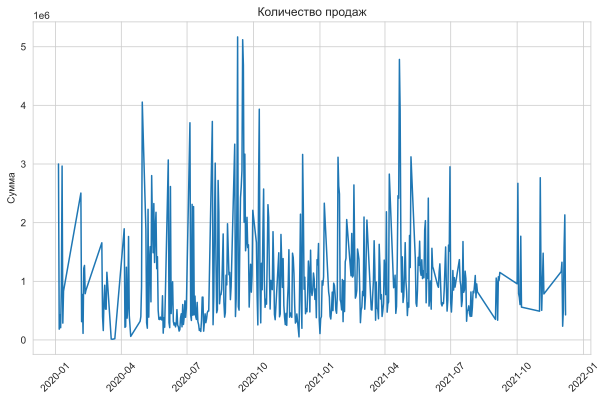

In [22]:
#График зависимости даты от суммы продаж или количество проданных товаров. 

plt.plot(df2['Дата2'], df2['Сумма'])
plt.title('Количество продаж')
plt.ylabel('Сумма')
plt.xticks(rotation = 45)
plt.show()

**Вывод:**

    На графике видно, что количество продаж по сумме в 2020 году было больше по сравнению с 2021 годом.

In [23]:
# Выводим в отдельном датафрейме самые продаваемые товары с максимальной выручкой за все время.

max_profit = df[['Товар','Количество', 'Сумма']].groupby('Товар').sum().sort_values('Сумма', ascending = False).reset_index()
max_profit.head()

,Товар,Количество,Сумма
0,3060.0,156,7114347.53
1,4757.0,281,6684277.87
2,4944.0,725,5092324.27
3,3487.0,435,4566229.85
4,2430.0,94,3805189.37


In [24]:
# Создадим датафрейм с указанием общего количества и суммы по каждому товару.

df_sum = df.groupby(['Товар'])['Количество', 'Сумма'].sum().reset_index()
df_sum

,Товар,Количество,Сумма
0,1.0,1,1495.00
1,2.0,1,14150.00
2,3.0,1,1200.00
3,4.0,1,2200.00
4,5.0,1,4580.89
...,...,...,...
5288,5519.0,1,5495.00
5289,5520.0,1,19450.00
5290,5521.0,1,14950.00
5291,5522.0,1,24700.00


In [25]:
''' Добавляем в созданный датафрейм создаваемые дополнительные признаки, а именно:
- процент продаж (Процент_продаж), который попадает именно на этот товар;
- количество проданных товаров (Процент_количество), т.е. процент каждого проданного товара от общего количество проданных 
товаров.
Потом считаем кумулитивную сумму по "Процент_продаж" и "Процент_количество", чтоб разброс наших значений был более выразительные
на графике. 
С помощью дополнительных признаков мы сможем посмотреть корреляцию и сделать кластеризацию.
Датафрейм нам покажет самый продаваемый товар по количеству, выручке, проценту продаж, проценту количества, и кумулятивную сумму
по продажам и по количеству.'''

df_sum['Процент_продаж'] = df_sum['Сумма'] / df_sum['Сумма'].sum() * 100
df_sum['Процент_количество'] = df_sum['Количество'] / df_sum['Количество'].sum() * 100
df_sum = df_sum.sort_values('Процент_продаж', ascending = False)
df_sum['Сумма_продаж'] = df_sum['Процент_продаж'].cumsum()
df_sum = df_sum.sort_values('Процент_количество', ascending = False)
df_sum['Сумма_количество'] = df_sum['Процент_количество'].cumsum()
df_sum.head()

,Товар,Количество,Сумма,Процент_продаж,Процент_количество,Сумма_продаж,Сумма_количество
4744,4944.0,725,5092324.27,1.033086,1.537776,3.832430,1.537776
4714,4911.0,580,1823693.31,0.369975,1.230221,13.936921,2.767997
3366,3487.0,435,4566229.85,0.926357,0.922666,4.758786,3.690663
417,434.0,430,1747247.86,0.354466,0.912060,14.291388,4.602723
2542,2635.0,425,1211674.74,0.245814,0.901455,24.168217,5.504179


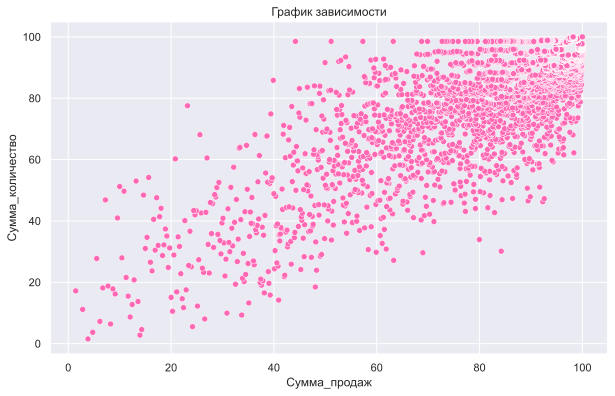

In [26]:
# Построим график рассеивания с помощью библиотеки 'seaborn' между признаком "Сумма_продаж" и "Сумма_количество".

sns.set()
ax = sns.scatterplot(x = 'Сумма_продаж', y = 'Сумма_количество', data = df_sum, color = 'hotpink')
plt.title('График зависимости')
# plt.savefig('График 1.png')
plt.show()

**Вывод:**
    
    График рассеивания показывает нам наличие корреляции между признаками 'Сумма_продаж', 'Сумма_количество'.

**Корреляция**

In [27]:
# Посмотрим на корреляцию между признаками в датафрейме "df_sum", которая больше или равна 50%.

corr = df_sum.corr()
corr_greater_than_50 = corr[corr>=.5]
corr_greater_than_50


,Товар,Количество,Сумма,Процент_продаж,Процент_количество,Сумма_продаж,Сумма_количество
Товар,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Количество,NaN,1.000000,0.733325,0.733325,1.000000,NaN,NaN
Сумма,NaN,0.733325,1.000000,1.000000,0.733325,NaN,NaN
Процент_продаж,NaN,0.733325,1.000000,1.000000,0.733325,NaN,NaN
Процент_количество,NaN,1.000000,0.733325,0.733325,1.000000,NaN,NaN
Сумма_продаж,NaN,NaN,NaN,NaN,NaN,1.000000,0.831256
Сумма_количество,NaN,NaN,NaN,NaN,NaN,0.831256,1.000000


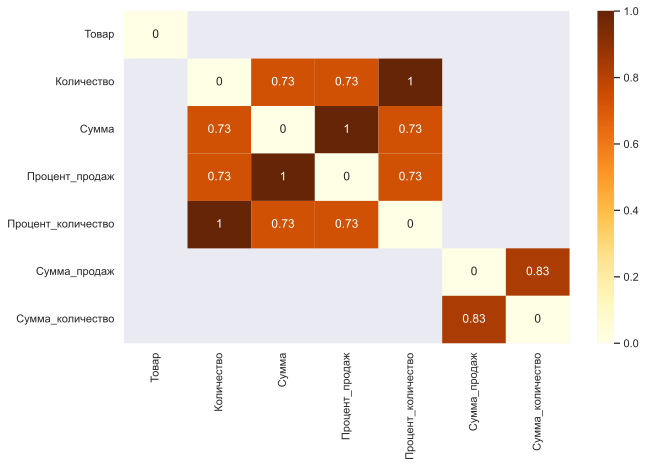

In [28]:
'''Построим heatmap (тепловую карту), чтоб посмотреть визуально на значения зависимости признаков. 
Так как главная диагональ это всегда 1, мы её обнулим чтоб она нам не мешала увидеть зависимости между признаками, которые нам 
интересны.'''

np.fill_diagonal(corr_greater_than_50.values, 0) 
sns.heatmap(corr_greater_than_50, cmap="YlOrBr", annot=True)
plt.show()

**Вывод:**
    
    Исходя из полученных коэффициентов корреляции в таблице выше и тепловой карты, мы видим, большую корреляция между
    признаками "Количество" и "Сумма", а также между дополнительными признаками, созданными на основе их, а именно:
    "Процент_продаж", "Процент_количество", "Сумма_продаж", "Сумма_количество". В частности, больше всего коррелирует между
    друг другом "Сумма_продаж" и "Сумма_количество.

### 5.	Выполнить проверку гипотез о данных

5.1 Зависит ли частота покупок от месяца?

In [29]:
# Создадим ноый датафрейм с помощью которого построим диаграмму рассеивания для проверки зависимости частоты покупок от месяца.

time = df[['Дата', 'Сумма']]
time.set_index('Дата', inplace = True)
time = time.resample('M').sum().sort_values('Дата', ascending = True)
time.head()

,Сумма
Дата,
2020-01-31,8835526.23
2020-02-29,7833534.37
2020-03-31,6075039.39
2020-04-30,12440633.74
2020-05-31,28976122.57


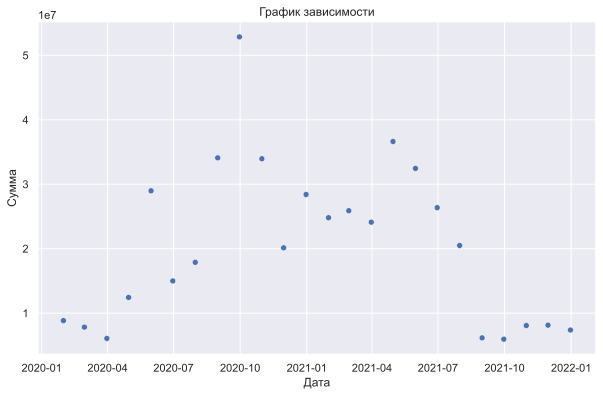

In [30]:
# Построим диаграмму рассеивания для проверки зависимости частоты покупок от месяца.

sns.set()
ax = sns.scatterplot(x = 'Дата', y = 'Сумма', data = time)
plt.title('График зависимости')
plt.show()

**Вывод:**
    
    На графике видно, что разброс значений хаотичен, поэтому можно сказать, что частота покупок не зависит от даты покупки, 
    т.е. между признаками "Дата" и "Сумма" зависимости нет.

 5.2 Больше лучших клиентов, чем потерянных клиентов?
 
 Т.е. выяснить больше ли клиентов, которые покупали совсем недавно, чаще всего и тратят больше всего, 
 чем клиентов, у которых последняя покупка была давно, и покупали мало и тратили мало.

In [31]:
# Выделяем три признака, которые нам помогут получить ответ о давности покупки, частоте покупки и сумме.

Now = df['Дата2'].max()
df3 = df.groupby(['Транзакция', 'Клиент', 'Дата2'])['Количество', 'Сумма'].sum() \
              .reset_index().drop_duplicates() \
              . groupby('Клиент').agg({'Дата2' : lambda x: (Now - x.max()).days,
                                      'Транзакция' : lambda x : len(x),
                                      'Сумма' : lambda x : x.sum()})
df3.head()

,Дата2,Транзакция,Сумма
Клиент,,,
1,382,3,14940.0
2,205,4,88540.0
3,642,1,7100.0
4,65,26,351196.5
5,581,1,3035.0


In [32]:
# Сегментируем клиентов по признакам дате(Дата2), транзакциям(Транзакция) и сумме(Сумма) с помощью ф-ции qcut и квантилей.

bin_labels = ['1', '2', '3', '4',]
bin_labels2 = ['1', '4']

df3['quantile_Затраты'] = pd.qcut(df3['Сумма'], q = [0, 0.25, 0.5, 0.75, 1], labels = bin_labels)
df3['quantile_Давность'] = pd.qcut(df3['Дата2'], q = [0, 0.25, 0.5, 0.75, 1], labels = bin_labels)    
df3['quantile_Частота'] = pd.qcut(df3['Транзакция'], q = [0.25, 0.75, 1], labels = bin_labels2)
df3['Сегменты_клиентов'] = df3['quantile_Затраты'].astype(str) \
                         + df3['quantile_Давность'].astype(str) \
                         + df3['quantile_Частота'].astype(str)
df3.head()

,Дата2,Транзакция,Сумма,quantile_Затраты,quantile_Давность,quantile_Частота,Сегменты_клиентов
Клиент,,,,,,,
1,382,3,14940.0,2,3,4,234
2,205,4,88540.0,4,2,4,424
3,642,1,7100.0,1,4,1,141
4,65,26,351196.5,4,1,4,414
5,581,1,3035.0,1,4,1,141


In [33]:
# Считаем количесвто значений равные 4-му квантилю.

pd.qcut(df3['Сумма'], q=4).value_counts()

(534.999, 7490.0]        2755
(41490.0, 6300874.84]    2747
(17545.0, 41490.0]       2746
(7490.0, 17545.0]        2741
Name: Сумма, dtype: int64

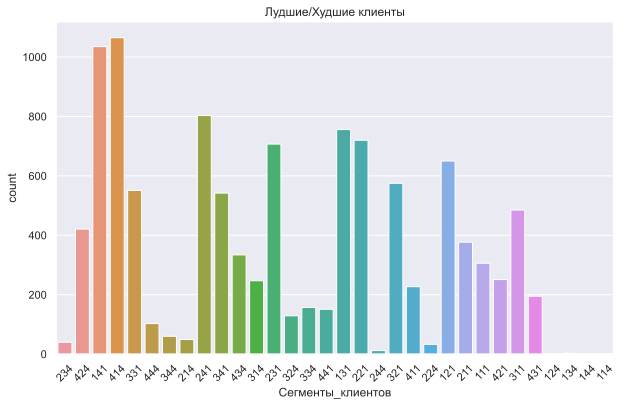

In [34]:
# С помощью библиотеки seaborn построим график, который отображает нам лучших и худших клиентов.

sns.set()
ax = sns.countplot(x = 'Сегменты_клиентов', data = df3)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plt.title('Лудшие/Худшие клиенты')
plt.show()

**Вывод:**
    
    На графике видим, что самый худший клиент это под номером 444, т.е. это тот клинет, который покупал давно, мало и на 
    небольшую сумму,  а самый лучший клиент это под номером 111, т.е. тот который покупает, часто, много и на большие суммы.

### 6. Кластеризация по товарам

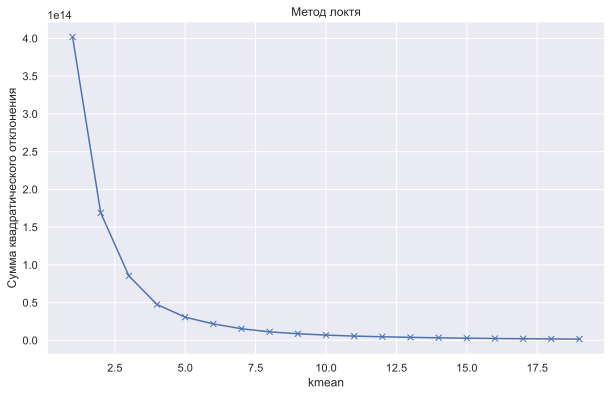

In [35]:
'''Выполним кластерный анализ на основе K средних.  С помощью готового класса 'Kmeans' из библиотеки 'scikit-learn, определим
сколько кластеров в нашем датасете, создав модель по формированию наших кластеров и обучив её. С помощью метода локтя, 
определяем визуально оптимальное количество классов, отметив каждый излом перекрестием для большей наглядности.'''

Sum_of_squared_distances = []
 

for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans = kmeans.fit(df_sum[['Количество', 'Сумма']])
    Sum_of_squared_distances.append(kmeans.inertia_)
    
plt.plot(range(1, 20), Sum_of_squared_distances, 'bx-')
plt.title('Метод локтя')
plt.xlabel('kmean')
plt.ylabel('Сумма квадратического отклонения')
plt.show()

**Вывод:**

    Рассмотрев график созданный с помощью matplotlib по методу локтя, видим пять класстеров. 

In [36]:
'''Создаем шаблом модели, обучаем её, предсказываем и добаляем в существующий датафрейм "df_sum" новый признак "№_кластера". 
Выводим датафрейм.'''

kmeans = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans = kmeans.fit(df_sum[['Количество', 'Сумма']])
predict = kmeans.predict(df_sum[['Количество', 'Сумма']])
df_sum['№_кластера'] = predict
df_sum.head()

,Товар,Количество,Сумма,Процент_продаж,Процент_количество,Сумма_продаж,Сумма_количество,№_кластера
4744,4944.0,725,5092324.27,1.033086,1.537776,3.832430,1.537776,2
4714,4911.0,580,1823693.31,0.369975,1.230221,13.936921,2.767997,4
3366,3487.0,435,4566229.85,0.926357,0.922666,4.758786,3.690663,2
417,434.0,430,1747247.86,0.354466,0.912060,14.291388,4.602723,4
2542,2635.0,425,1211674.74,0.245814,0.901455,24.168217,5.504179,1


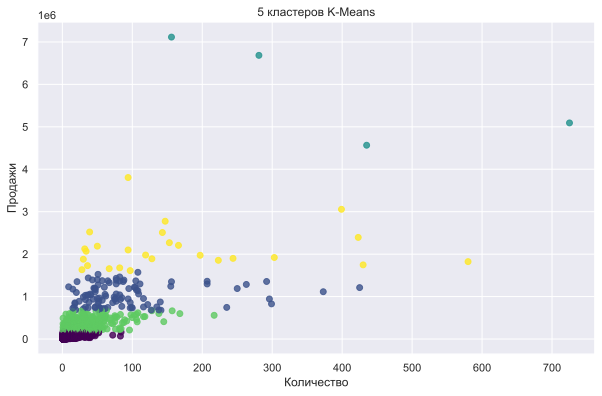

In [37]:
'''С помощью библиотеки matplotlib построили диаграмму рассеивания для визуализации наших кластеров чтоб посмотреть как 
засвисит признак 'Сумма' от 'Количество'. '''

plt.scatter(x = df_sum['Количество'], y = df_sum['Сумма'], c = df_sum['№_кластера'], cmap = 'viridis', alpha = 0.8)
plt.title('5 кластеров K-Means')
plt.xlabel('Количество')
plt.ylabel('Продажи')
plt.show()

**Вывод:**

    На графике видим распределения значений наших 5 кластеров по цветам, а также видим, что между признаком "Количество" 
    и "Сумма" есть зависимость.

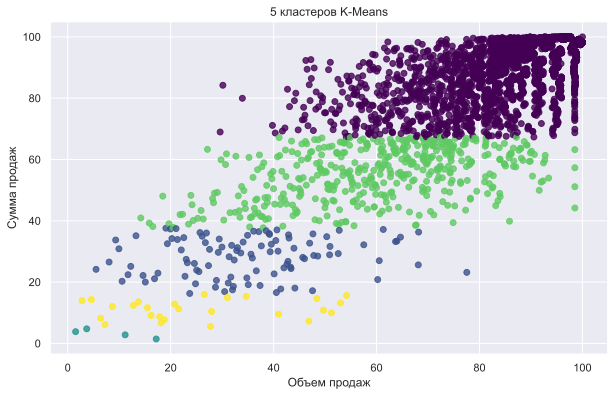

In [38]:
'''Построили диаграмму рассеивания для визуализации наших кластеров, но используя созданные дополнительные признаки, так как они
позволяют маштабировать наши текущие значения признаков для более четкого результата в корреляции и более четкого выделения
наших кластеров.'''

plt.scatter(x = df_sum['Сумма_количество'], y = df_sum['Сумма_продаж'], c = df_sum['№_кластера'], cmap = 'viridis', alpha = 0.8)
plt.title('5 кластеров K-Means')
plt.xlabel('Объем продаж')
plt.ylabel('Сумма продаж')
plt.show()

**Вывод:**
    
    На диаграмме рассеивания видим сформированные пять кластеров, но уже с более четкими границами. Также на этой диаграмме 
    видим корреляцию между дополнительными признаками 'Объем продаж' и 'Сумма продаж', которые были созданы на основе 
    признаков "Количество" и "Сумма".

### 7. Важные признаки

**Определим какие признаки важны для построения модели машинного обучения либо статистического анализа.**

In [39]:
'''Вычисляем важность признаков используя готовую модель "SelectKBest" и "chi2" из библиотеки scikit-learn, которая рассчитывает 
числовое значения важности нашего признака.'''

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = df_sum[['Товар', 'Количество', 'Сумма', 'Процент_продаж', 'Процент_количество', 'Сумма_продаж', 'Сумма_количество', '№_кластера']]
y = df_sum.iloc[:, -1]

bestfeatures = SelectKBest(score_func = chi2, k = 'all')
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'Score']  
print(featureScores.nlargest(10, 'Score'))  


                Specs         Score
2               Сумма  3.986792e+09
1          Количество  2.461520e+05
0               Товар  9.722370e+04
7          №_кластера  1.391201e+04
5        Сумма_продаж  1.297965e+04
6    Сумма_количество  8.828964e+03
3      Процент_продаж  8.088053e+02
4  Процент_количество  5.221059e+02


**Вывод:** 

    Из полученных данных мы можем видеть какие признаки для нас важны. Чем выше значение в полученной таблице, тем важнее
    признак.

### 8.	Рекомендации

In [40]:
# Создаем датафрейм.

df_all = df[['Товар', "Клиент", "Количество"]].groupby(["Товар", "Клиент"]) \
        .sum().sort_values("Количество", ascending = False).reset_index()
df_all

,Товар,Клиент,Количество
0,2602.0,4997,21
1,5302.0,22,19
2,2519.0,1572,14
3,5305.0,1323,14
4,5305.0,3397,13
...,...,...,...
41365,2523.0,6621,1
41366,2523.0,6780,1
41367,2523.0,6967,1
41368,2523.0,7172,1


In [41]:
# Создадим сводную таблицу и заменим пустые значения NaN на нули.

df_pivot = pd.pivot_table(df_all, values='Количество', index='Клиент', columns='Товар')
df_pivot.fillna(0, inplace=True)
df_pivot

Товар,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,5514.0,5515.0,5516.0,5517.0,5518.0,5519.0,5520.0,5521.0,5522.0,5523.0
Клиент,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Cоздаем шаблон из 10 соседей(точек) и обучаем её.

knn = NearestNeighbors(n_neighbors=10, algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(df_pivot)

In [43]:
# Создаём функцию, которая ищет клиентов похожих на клиента, которому надо дать рекомендацию. Выводим результат работы функции.

def most_similar_users_to(user_id):
    most_similar_users_to = []
    distance, indice = model_knn.kneighbors(df_pivot.iloc[user_id,:].values.reshape(1,-1), n_neighbors=10)
    print('Рекомендации для клиента ## {0} ##:'.format(df_pivot.index[user_id]))
    for i in range(1, len(distance.flatten())):
        user_id1 = df_pivot.index[indice.flatten()[i]]
        most_similar_users_to.append((user_id1, distance.flatten()[i]))

    most_similar_users_to.sort(key=lambda x: x[1], reverse=True)

    return most_similar_users_to[:10]

print("Подобие (схожесть) на основе пользователя")
print(most_similar_users_to(77))

Подобие (схожесть) на основе пользователя
Рекомендации для клиента ## 78 ##:
[(5492, 0.7113248654051871), (5858, 0.6464466094067263), (2218, 0.6464466094067263), (503, 0.6464466094067263), (2000, 0.6464466094067263), (1580, 0.6464466094067263), (1926, 0.5527864045000421), (396, 0.5), (7096, 0.5)]


In [44]:
''' Создаём функцию, которая суммирует все коэффициенты подобия и на их основе формирует сортированный список товаров, и
дополнительно товаров, которые не приобретал данный клиент. Выводим результат'''

def user_based_suggestions(user_id):
    suggestions = defaultdict(float)
    non_interacted_movies = df_pivot.iloc[user_id][df_pivot.iloc[user_id]==0].index.tolist()
    for other_user_id, similarity in most_similar_users_to(user_id):
        movies_user_id = df_pivot.loc[other_user_id][df_pivot.loc[other_user_id]>0]
        for interest in movies_user_id.index.tolist():
            if interest in non_interacted_movies:
                suggestions[interest] += similarity

    suggestions = sorted(suggestions.items(),
                         key=lambda x: x[1],
                         reverse=True)
    return suggestions[:10]

print("Рекомендации для пользователя")
print(user_based_suggestions(21))

Рекомендации для пользователя
Рекомендации для клиента ## 22 ##:
[(3736.0, 0.31136364252188764), (5125.0, 0.31136364252188764), (5338.0, 0.31136364252188764), (1847.0, 0.2877272006974865), (1898.0, 0.2877272006974865), (3504.0, 0.2877272006974865), (3528.0, 0.2877272006974865), (3854.0, 0.2877272006974865), (4525.0, 0.2877272006974865), (4526.0, 0.2877272006974865)]


In [45]:
print("Рекомендации для пользователя")
print(user_based_suggestions(21))

Рекомендации для пользователя
Рекомендации для клиента ## 22 ##:
[(3736.0, 0.31136364252188764), (5125.0, 0.31136364252188764), (5338.0, 0.31136364252188764), (1847.0, 0.2877272006974865), (1898.0, 0.2877272006974865), (3504.0, 0.2877272006974865), (3528.0, 0.2877272006974865), (3854.0, 0.2877272006974865), (4525.0, 0.2877272006974865), (4526.0, 0.2877272006974865)]


## Вывод:

    В ходе выполнения анализа данных о покупках клиентов, была получена следующая информация:
    - График распределения плотности показывает, что данные не распределены нормально, они смещены в лево;
    - Столбчатая диаграмма показывает, что повышенная частота покупок приходится на временной интервал с 15 до 20 часов;
    - График зависимости показывает, что количество продаж по сумме в 2021 году упало по сравнению с 2020 годом;
    - Диаграммы рассеивания, тепловая карта и расчет корреляции показывают наличие зависимости между признаком "Сумма" и 
    "Количество", а также между дополнительными признаками, созданными на основе их, а именно: "Процент_продаж",
    "Процент_количество", "Сумма_продаж", "Сумма_количество". Больше всего коррелирует между друг другом "Сумма_продаж" и 
    "Сумма_количество;
    - Частота покупок не зависит от даты покупки, т.е. между признаками "Дата" и "Сумма" зависимости нет, что видно на 
    графике рассеивания;
    - Самым худшим клиентом оказался клиент под номером 444, а самым лучшим клиент под номером 111;
    - На диаграммах рассеивания видим 5 кластеров, а также корреляцию между признаком "Количество" и "Сумма" и 
    дополнительными признаками 'Объем продаж' и 'Сумма продаж', которые были созданы на основе признаков "Количество" и
    "Сумма". 
    - Анализ важности признаков, подтверждает выявленные зависимости между признаком "Количество" и "Сумма" и 
    дополнительными признаками, созданными на их основе.